## Подготовка данных и разведовательный анализ

In [12]:
# imports
import pandas as pd
from functools import reduce

#### Константы
- пути к данным
- признаки, описывающие данные
- типы "столбцов", или "подпризнаков"
- ID ТС

In [13]:
DATA_PATH = 'data/vehicle_dataset_public/'
DATA_PROC_PATH = 'data/vehicle_proccessed/'

TAGS_FEATURES = ['fuelLevel', 'ingection', 'speedAndHeight', 'tachometer']
TAGS_TARGET = ['refueling2']
TAGS = TAGS_FEATURES + TAGS_TARGET

TIME_COLUMNS = ['DTIME', 'STARTDATE', 'ENDDATE']
FLOAT_COLUMNS = ['BEVALUE', 'SPEED', 'HEIGHT']

VEHICLE_IDS = [1, 3, 5, 19, 28]

Словарь, состоящий из dataframe'ов для каждого признака

In [14]:
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        df = pd.read_csv(DATA_PATH +
                         f'vehicle{i}_{tag}_public.csv', sep=';')
        for col in FLOAT_COLUMNS:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.replace(',','.').astype(float)
        df.rename(columns={'BEVALUE': tag}, inplace=True)

        for time_col in TIME_COLUMNS:
            if time_col in df.columns:
                df[time_col] = pd.to_datetime(df[time_col])

        dict_df_vehicle[tag] = df

    return dict_df_vehicle

Объединение всех "исходных" признаков из словаря dataframe'ов в один dataframe

In [15]:
def df_summary(dict_df):
    df_to_merge = [dict_df[name] for name in TAGS_FEATURES]

    df_res = reduce(lambda left, right: pd.merge(left, right, how='outer', on='DTIME'),
                    df_to_merge)
    df_res.columns = df_res.columns.str.lower()

    return df_res

Объединение всех таблиц в единую таблицу vehicle{i}.csv (для каждого ТС)

In [16]:
def combine_data():
    for i in VEHICLE_IDS:
        dict_df = dict_df_vehicle_i(i)

        df_sum = df_summary(dict_df)
        df_refuel = dict_df['refueling2']

        df = df_sum.copy()
        df['refuel'] = [1 if ((df_refuel['STARTDATE'] < date) & (date <= df_refuel['ENDDATE'])).any()
                        else 0 for date in df_sum['dtime']]
        df.sort_values(by=['dtime'], inplace=True)

        name = f'vehicle{i}'

        df.to_csv(f'{DATA_PROC_PATH}{name}.csv', index_label='i')

In [17]:
#combine_data()

#### Графики уровней топлива

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

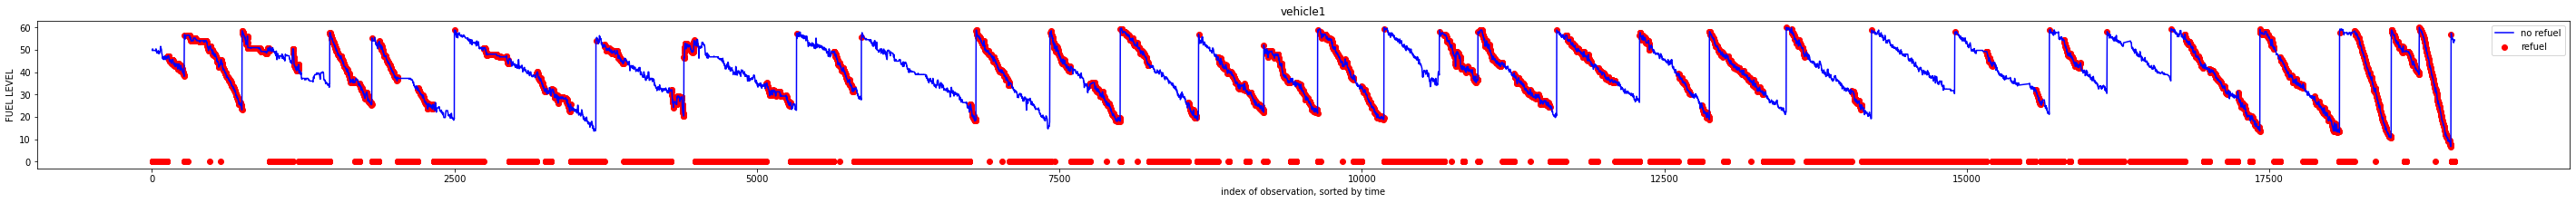

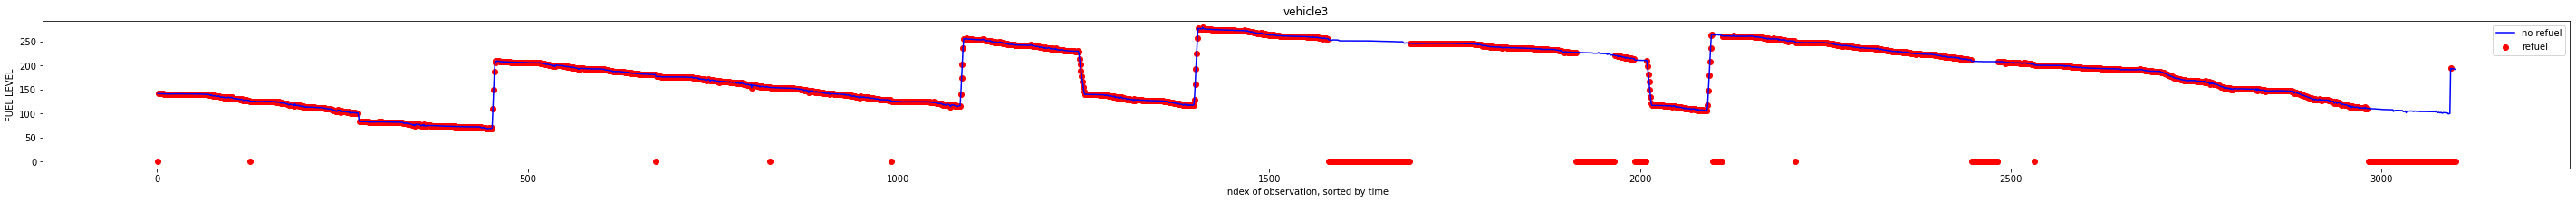

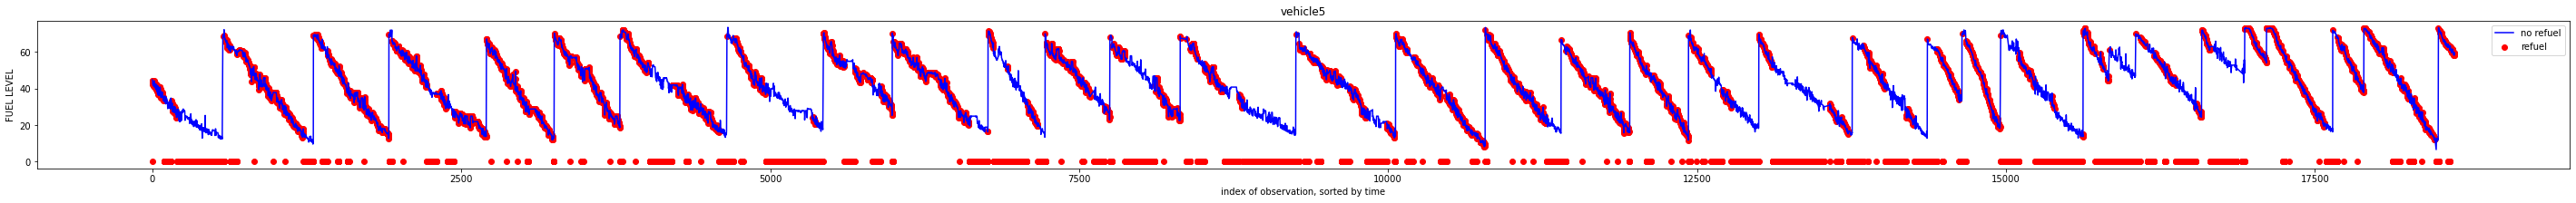

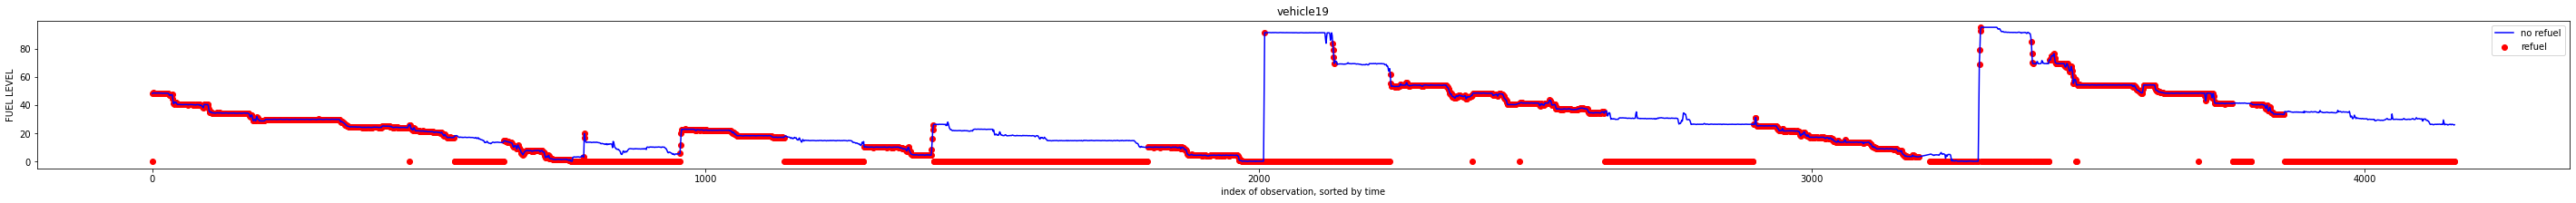

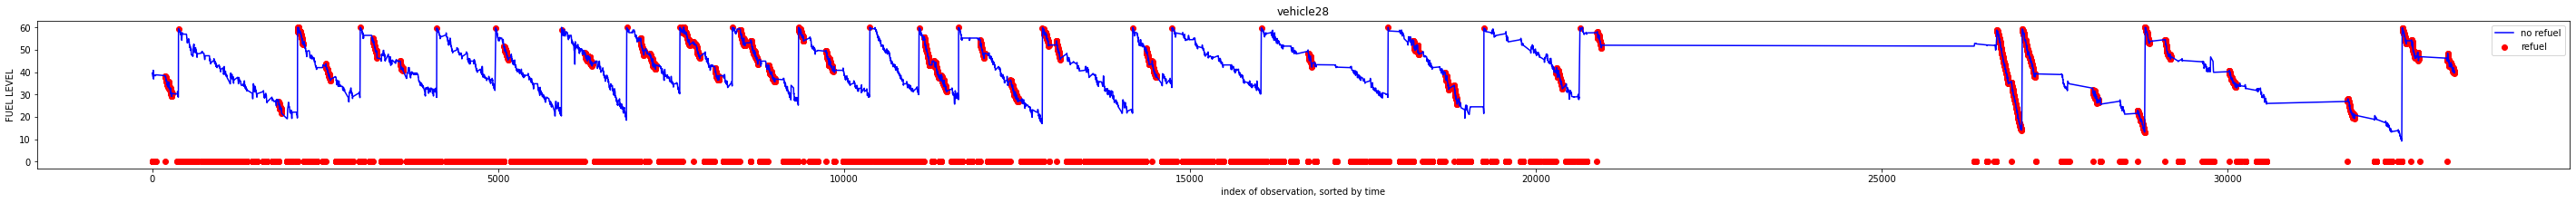

In [19]:
for i in VEHICLE_IDS:
    df = pd.read_csv(f'{DATA_PROC_PATH}vehicle{i}.csv')
    df.dropna(inplace=True)
    df = df[df['fuellevel'] > 0]
    df.reset_index(inplace=True)

    df_refuel = df[df['refuel'] == 1]

    plt.figure(figsize=(50, 3))

    plt.title(f'vehicle{i}')
    plt.ylabel('FUEL LEVEL')
    plt.xlabel('index of observation, sorted by time')
    plt.plot(df['i'], df['fuellevel'], color='blue', label='no refuel')
    plt.scatter(df['i'], df['fuellevel'] * df['refuel'], color='red', label='refuel')
    plt.legend()

    plt.savefig(f'{DATA_PROC_PATH}plots/fuellevel_refuel_vehicle{i}.png', dpi=160)
    plt.show()


#### Выбор метода сглаживания fuellevel

Графики для подбора техники сглаживания уровня топлива
(метод так же выбирается на основе анализа сглаживания в rolling_data)

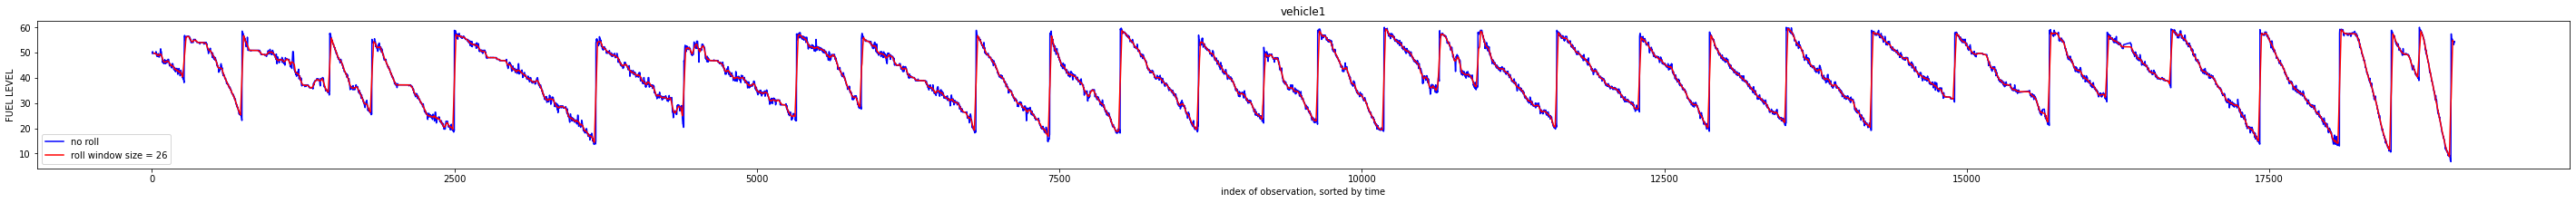

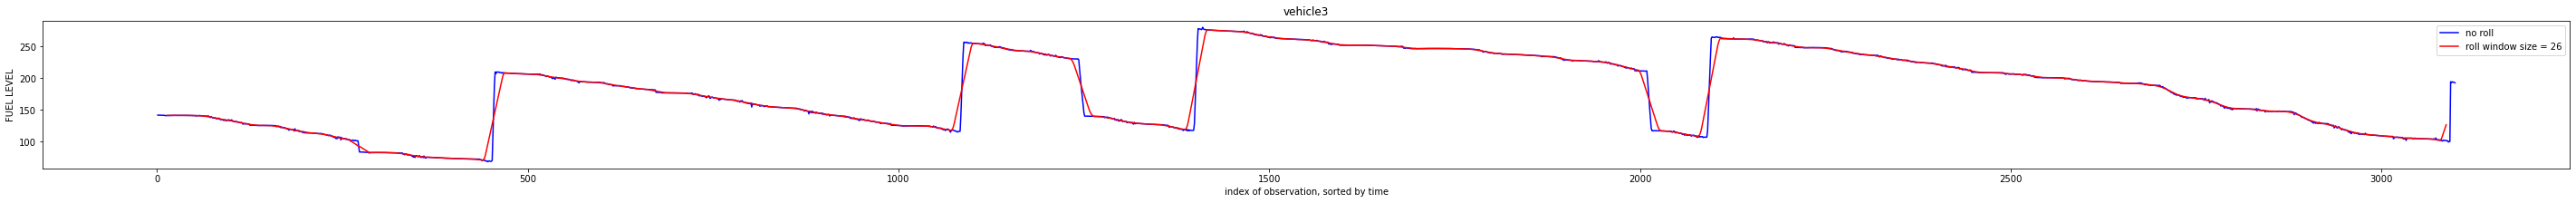

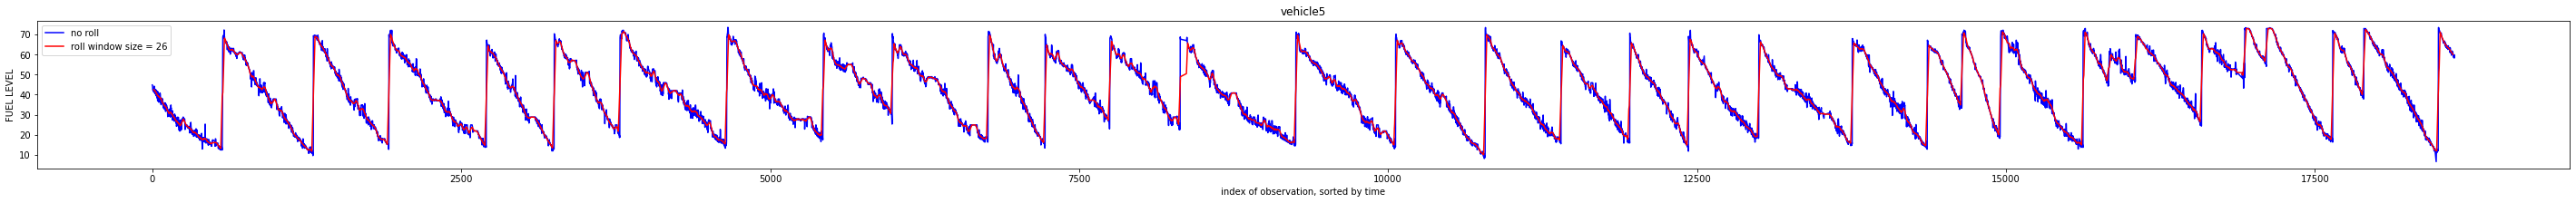

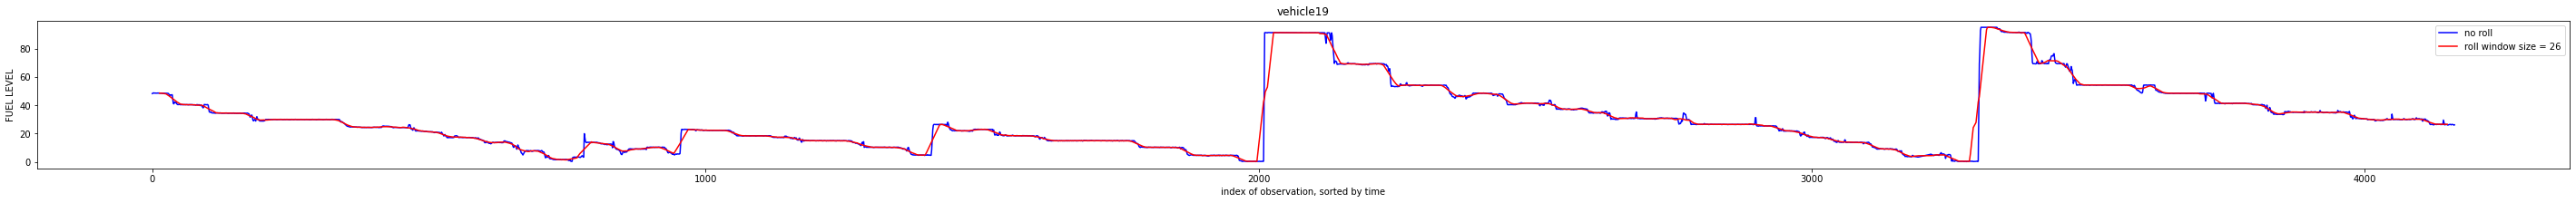

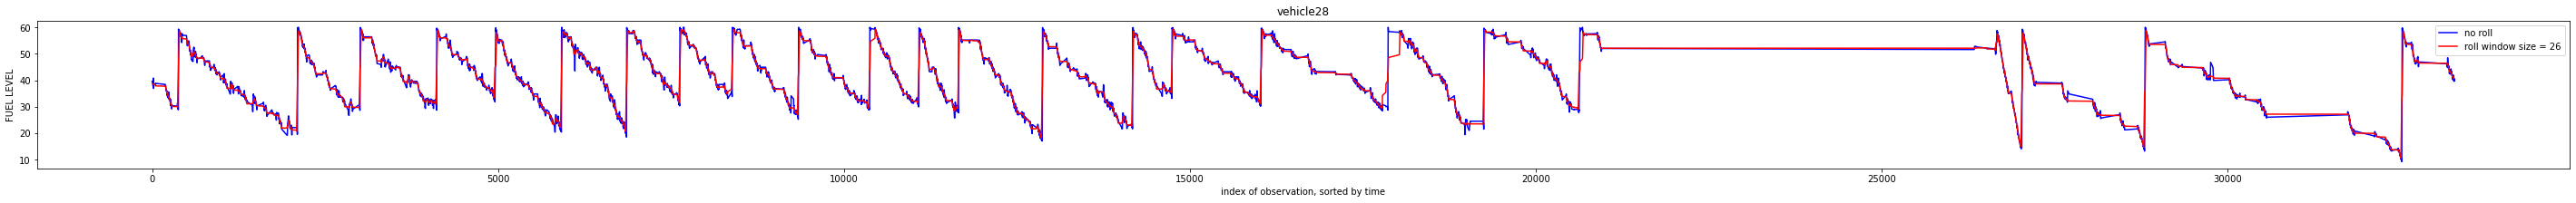

In [23]:
for i in VEHICLE_IDS:
    df = pd.read_csv(f'{DATA_PROC_PATH}vehicle{i}.csv')
    df.dropna(inplace=True)
    df = df[df['fuellevel'] > 0]
    df.reset_index(inplace=True)

    plt.figure(figsize=(50, 3))

    plt.title(f'vehicle{i}')
    plt.ylabel('FUEL LEVEL')
    plt.xlabel('index of observation, sorted by time')

    fuellevel_rolled = df['fuellevel'].rolling(26, center=True).mean()

    plt.plot(df['i'], df['fuellevel'], color='blue', label='no roll')
    plt.plot(df['i'], fuellevel_rolled, color='red', label='roll window size = 26')
    plt.legend()

    plt.savefig(f'{DATA_PROC_PATH}plots/fuellevel_vehicle_rolled{i}.png', dpi=160)
    plt.show()

win_type = 'default' показал лучшие результаты, сглаживаем им:

In [21]:
for i in VEHICLE_IDS:
    df = pd.read_csv(f'{DATA_PROC_PATH}vehicle{i}.csv', index_col='i')
    df.dropna(inplace=True)
    df = df[df['fuellevel'] > 0]

    df['fuellevel'] = df['fuellevel'].rolling(26, center=True).mean()

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.to_csv(f'{DATA_PROC_PATH}vehicle{i}_rolled.csv', index_label='i')

#### Составление pandas_profiling отчетов

In [22]:
import pandas as pd
import pandas_profiling

ModuleNotFoundError: No module named 'confuse'

In [ ]:
for i in VEHICLE_IDS:
    name = f'vehicle{i}'

    df_vehicle = pd.read_csv(f'{DATA_PROC_PATH}{name}.csv')

    report = pandas_profiling.ProfileReport(df_vehicle, explorative=True)

    report.to_file(f'{DATA_PROC_PATH}reports/{name}.csv')

### Итоги разведовательного анализа:
- из графиков уровней топлива и отчетов видно, что с __refueling2 проблема__
- отдельные таблицы объединены в одну vehicle{i}.csv
- из отчетов видно, что между speed, tachometer и fuellevel есть некоторая корреляция
